In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## 把imb.pickle丟到你的雲端然後執行**上面**那個cell

In [2]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
#import pickle5 as pickle
import copy
import pickle
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import AdaBoostClassifier as AdaBC
from sklearn.model_selection import GridSearchCV 

In [4]:
from xgboost import XGBClassifier

In [5]:
with open('/content/drive/MyDrive/imb.pickle','rb') as handle:
    imb = pickle.load(handle)

In [6]:
#display(imb)

In [7]:
X_train = np.vstack((imb["X_subtrain"],imb["X_valid"]))
y_train = np.vstack((imb["y_subtrain"].reshape(-1,1),imb["y_valid"].reshape(-1,1))).reshape(imb["y_subtrain"].shape[0]+imb["y_valid"].shape[0],)

#### optimal function : 

In [8]:
from sklearn.metrics import confusion_matrix


def opt_score(y_true, y_predict):
    def specificity_score(y_true, y_predict):
        conf = confusion_matrix(y_true=y_true, y_pred=y_predict)
        return conf[0,0]/(conf[0,0]+conf[0, 1])
    target1_pro = 0.919271
    target0_pro = 1 - target1_pro 
    opt_score = specificity_score(y_true, y_predict)*target1_pro*0.03 - (1-recall_score(y_true, y_predict))*target0_pro
    return (opt_score+0.1)*5

In [9]:
from sklearn.metrics import make_scorer
my_scorer = make_scorer(opt_score,greater_is_better=True)

## Start training ~

ref https://xgboost.readthedocs.io/en/latest/parameter.html

In [10]:
def opt_score2(y_true, y_predict, x_train):
    import numpy as np
    pos_index = (y_predict > 0.5).nonzero()
    neg_index = (y_predict < 0.5).nonzero()
    true_index = (y_true == 1).nonzero()
    false_index = (y_true == 0).nonzero()
    
    # specificity 
    s_index = np.intersect1d(neg_index, false_index)
    s_loss = x_train[s_index,3].sum() # annuty
    # (1-recall)
    invr_index = np.intersect1d(neg_index, true_index)
    invr_loss = x_train[invr_index, 2].sum() # credict
    
    return (s_loss - invr_loss)/x_train.shape[0]

# Tuning with opt_score2
- two stage tuning :  
  **pros** : saving time  
  **cons** : too greedy to reach the real maximum  
  It will be better to tuning all 4 variables together, but it is really time consuming, so i split the tuning process into two phase :
  - phase I :  
  tuning learning rates and number of estimators
  - pahse II :  
  tuning max depth of decision tree and subsampling rate

In [11]:
XGBC_DT = dict()

In [12]:
l_r = [0.05,0.075,0.1,0.15]
n_est = [200,400,500,600,800,1000]
max_d=[5,7,10]
sub_s = [0.7, 0.8, 0.85, 0.95]

## phase I

In [14]:
best_l = 0
best_n = 0
best_opt = 0

# it will take a lot of time to run through all the parameter combinations, so i interrrupt the cell.

In [16]:

for l in l_r:
    for n in n_est:
        tStart = time.time()
        # --------------------------------------------------------- #
        # train
        xgbc = XGBClassifier(booster="gbtree",
                     nthread=-1,
                     learning_rate=l,
                     n_estimators=n,
                     objective='binary:logistic',
                     gamma=0,
                     min_child_weight=1,
                     max_delta_step=0,
                     subsample=0.85,
                     colsample_bytree=0.7,
                     colsample_bylevel=1,
                     reg_alpha=0,
                     reg_lambda=1,
                     scale_pos_weight=11,
                     seed=46,
                     missing=None)
        xgbc.fit(imb["X_subtrain"],imb["y_subtrain"])
        XGBC_DT[str(l)+'@'+str(n)] = xgbc
        # valid
        ypred = xgbc.predict(imb["X_valid"])
        opt = opt_score2(imb["y_valid"],ypred,imb["X_valid"])
        if opt > best_opt:
            print("! update best !")
            best_l = l
            best_n = n
            best_opt = opt
        # --------------------------------------------------------- #
        tEnd = time.time()
        print("l: %f, n: %d, opt: %f, spend %f sec\n"%(l,n,opt,tEnd-tStart))
print("best l: %f, best n: %d, opt: %f"%(best_l,best_n,best_opt))

! update best !
l: 0.050000, n: 200, opt: 603.242768, spend 111.596448 sec

! update best !
l: 0.050000, n: 400, opt: 869.050985, spend 220.085919 sec



KeyboardInterrupt: ignored

## phase II

In [15]:
best_s = 0
best_d = 0
best_opt = 0

In [ ]:
# d,s
for d in max_d:
    for s in sub_s:
        tStart = time.time()
        # --------------------------------------------------------- #
        # train
        xgbc = XGBClassifier(booster="gbtree",
                     nthread=-1,
                     max_depth = d,
                     learning_rate=0.1,
                     n_estimators=500,
                     objective='binary:logistic',
                     gamma=0,
                     min_child_weight=1,
                     max_delta_step=0,
                     subsample = s,
                     colsample_bytree=0.7,
                     colsample_bylevel=1,
                     reg_alpha=0,
                     reg_lambda=1,
                     scale_pos_weight=11,
                     seed=46,
                     missing=None)
        xgbc.fit(imb["X_subtrain"],imb["y_subtrain"])
        XGBC_DT[str(d)+'%'+str(s)] = xgbc
        # valid
        ypred = xgbc.predict(imb["X_valid"])
        opt = opt_score2(imb["y_valid"],ypred,imb["X_valid"])
        if opt > best_opt:
            print("! update best !")
            best_s = s
            best_d = d
            best_opt = opt
        # --------------------------------------------------------- #
        tEnd = time.time()
        print("s: %f, d: %d, opt: %f, spend %f sec\n"%(s,d,opt,tEnd-tStart))
print("best s: %f, best d: %d, opt: %f"%(best_s,best_d,best_opt))

s: 0.700000, d: 5, opt: -408.468219, spend 464.417295 sec

s: 0.800000, d: 5, opt: -68.480667, spend 432.741791 sec

s: 0.850000, d: 5, opt: -95.300706, spend 418.362647 sec

! update best !
s: 0.950000, d: 5, opt: 120.973658, spend 396.202784 sec

s: 0.700000, d: 7, opt: -3344.180483, spend 646.978391 sec

s: 0.800000, d: 7, opt: -2782.386539, spend 607.753908 sec

s: 0.850000, d: 7, opt: -2933.797263, spend 584.871762 sec

s: 0.950000, d: 7, opt: -2925.111593, spend 545.541530 sec

s: 0.700000, d: 10, opt: -10887.427722, spend 961.335171 sec

s: 0.800000, d: 10, opt: -10626.642479, spend 904.771529 sec

s: 0.850000, d: 10, opt: -10326.709511, spend 873.172464 sec

s: 0.950000, d: 10, opt: -10104.520337, spend 814.526368 sec

best s: 0.950000, best d: 5, opt: 120.973658


In [17]:
ts = time.time()
# -------------------------------------------------------------
xgbc_finale = XGBClassifier(booster="gbtree",
                     nthread=-1,
                     max_depth=5,
                     learning_rate=0.05,
                     n_estimators=200,
                     objective='binary:logistic',
                     gamma=0,
                     min_child_weight=1,
                     max_delta_step=0,
                     subsample=0.95,
                     colsample_bytree=0.85,
                     colsample_bylevel=1,
                     reg_alpha=0,
                     reg_lambda=1,
                     scale_pos_weight=11,
                     seed=46,
                     missing=None)
xgbc_finale.fit(imb["X_subtrain"],imb["y_subtrain"])
#xgbc_finale.fit(X_train,y_train)
# -------------------------------------------------------------
te = time.time()
print("cost: %f sec"%(te-ts))
ypredt_p = xgbc_finale.predict_proba(imb["X_test"])

cost: 190.039968 sec


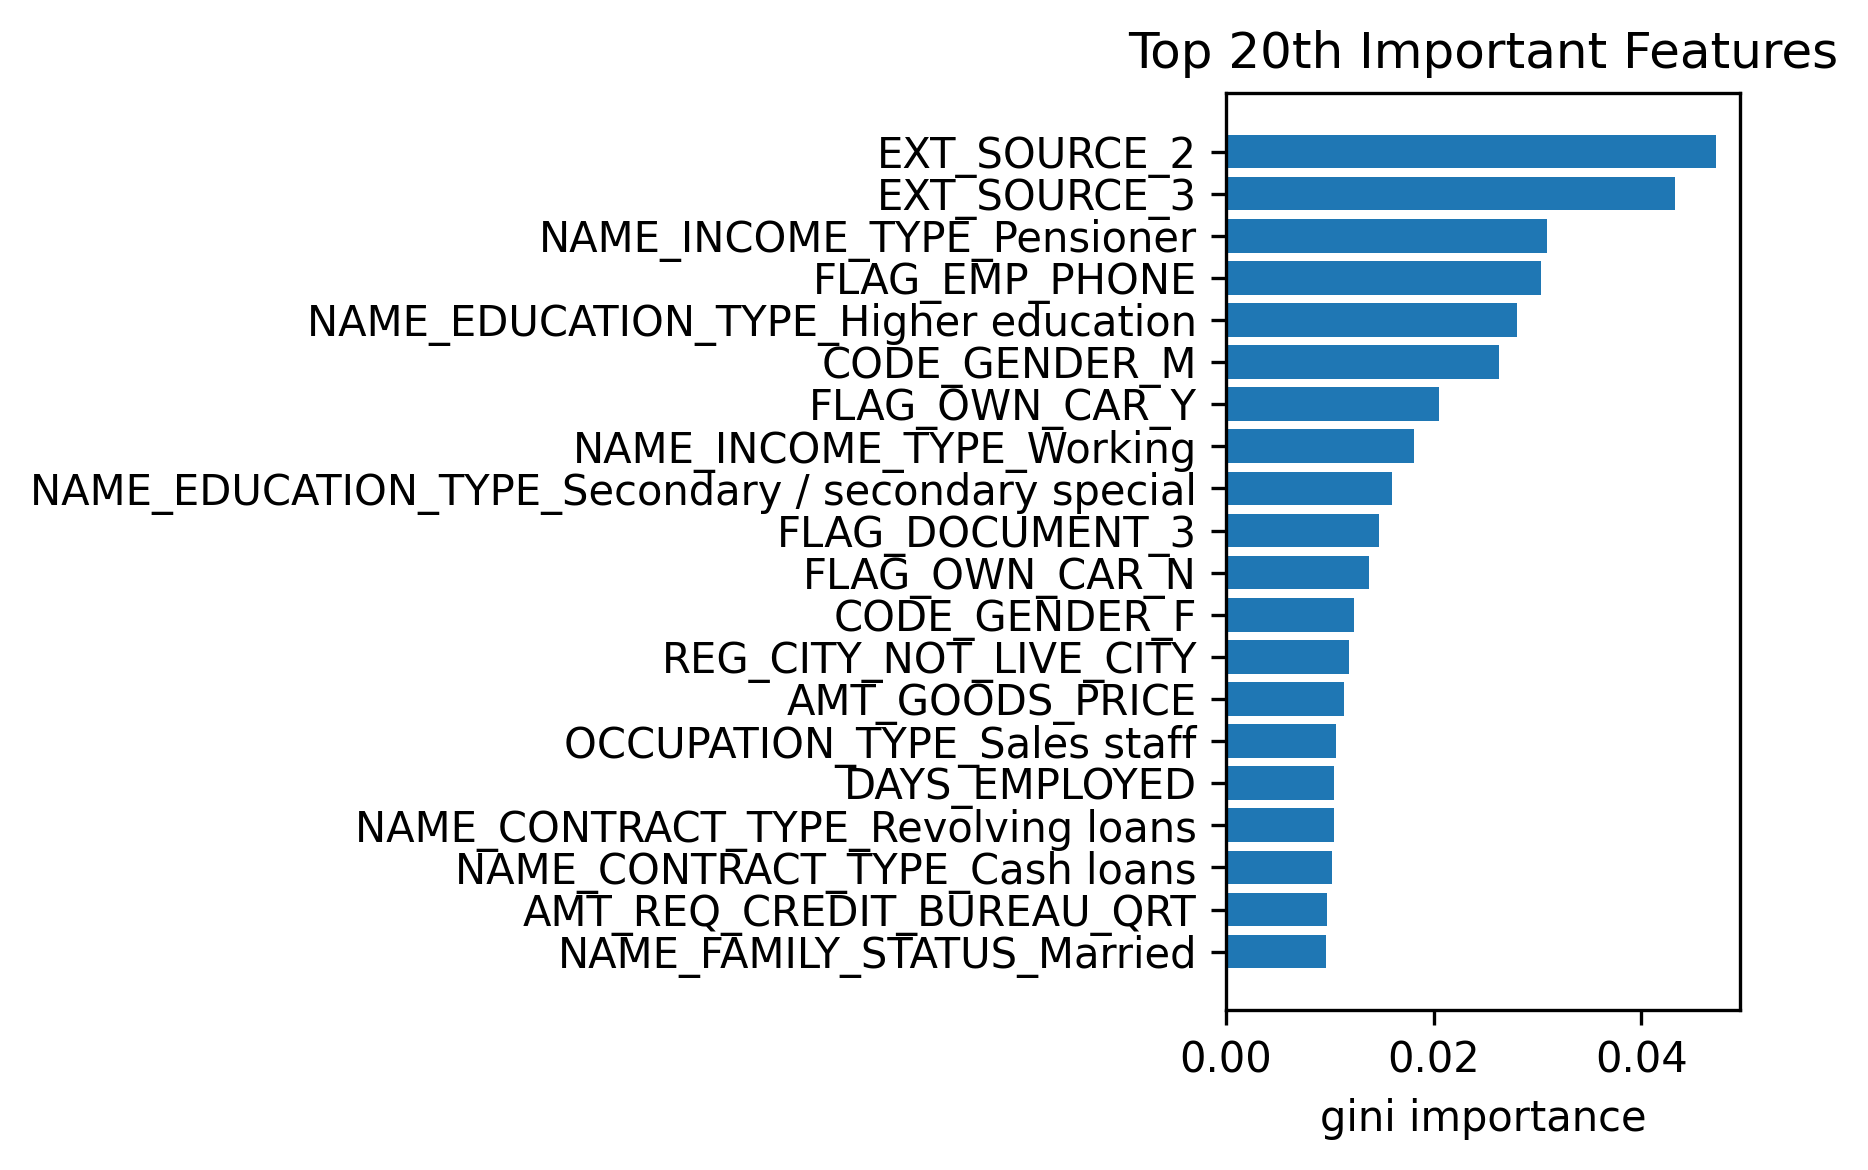

In [18]:
import pandas as pd
df1 = pd.read_csv('/content/drive/MyDrive/preprocessed.csv')
# 
col_name = list(df1.columns)
col_name=col_name[3:]

importances = xgbc_finale.feature_importances_

indices = np.argsort(importances)#[::-1]


labels = []
gini_im = []
for i in indices[-20:]:
    labels.append(col_name[i])
    gini_im.append(importances[i])
    
#plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 改字體，標題才可以是中文
plt.rcParams['figure.dpi'] = 300
plt.barh(labels, gini_im,)
plt.xlabel('gini importance')
plt.title('Top 20th Important Features')
plt.tight_layout()
plt.savefig('important_features_XGB.png', transparent = True)
plt.show()

In [ ]:

import joblib
joblib.dump(xgbc_finale,'L01_N500_S095_D5_XGBC')

['L01_N500_S095_D5_XGBC']

In [19]:
thresholds = [0.475,0.4875,0.5,0.5125,0.525]

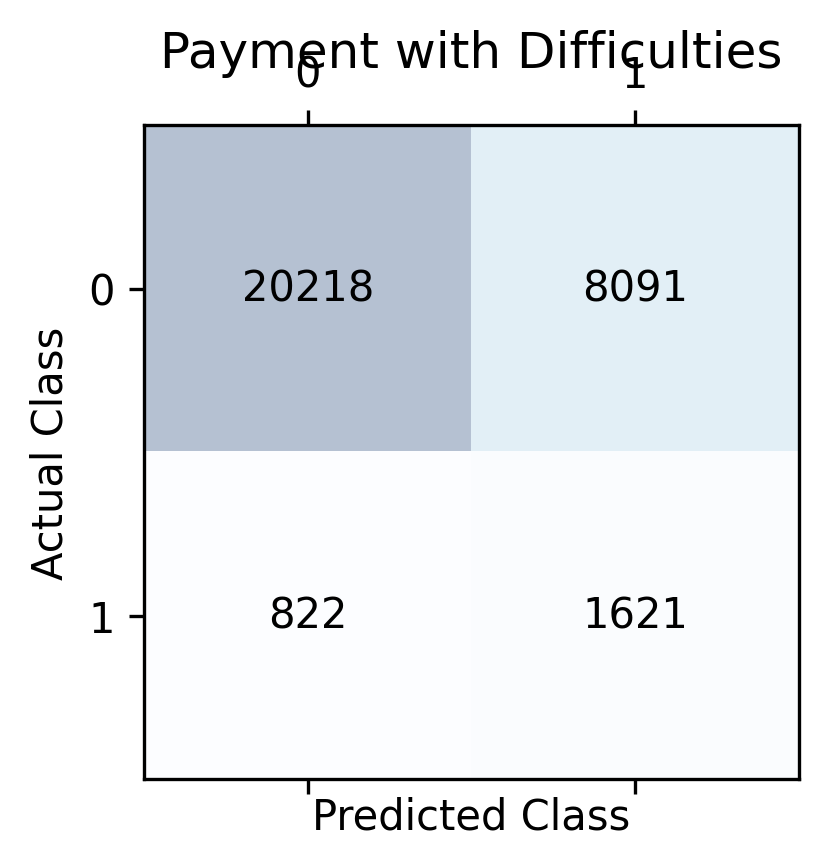

accuracy = 0.7101651925078044
f1_score = 0.2667215137803373
precision = 0.16690691927512355
recall = 0.6635284486287352
opt_score = 0.46266504102824985
opt_score2 = 1327.868902835588
-----------------


In [20]:
# subsample 0.85
for th in [0.5]:
    yp_th = ypredt_p[:,1] > th
    confmat = confusion_matrix(y_true=imb["y_test"], y_pred=yp_th)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xticks([0, 1], [0, 1])
    plt.yticks([0, 1], [0, 1])
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Payment with Difficulties')
    plt.tight_layout()
    #if np.abs(th-0.5) < 0.01:
    plt.savefig("imb_XGBC.png", transparent = True)
    plt.show()

    acc = accuracy_score(imb["y_test"],yp_th)
    f1 = f1_score(imb["y_test"], yp_th)
    precision = precision_score(imb["y_test"], yp_th)
    recall = recall_score(imb["y_test"], yp_th)
    #spe = specificity_score(imb["y_test"],yp_th)
    opt = opt_score(imb["y_test"], yp_th)
    opt2 = opt_score2(imb["y_test"],yp_th,imb["X_test"])
    print('accuracy =', acc)
    print('f1_score =', f1)
    print('precision =', precision)
    print('recall =', recall)
    #print('specificity =', spe)
    print('opt_score =', opt)
    print('opt_score2 =', opt2)
    print('-----------------')

AUC: 0.758034


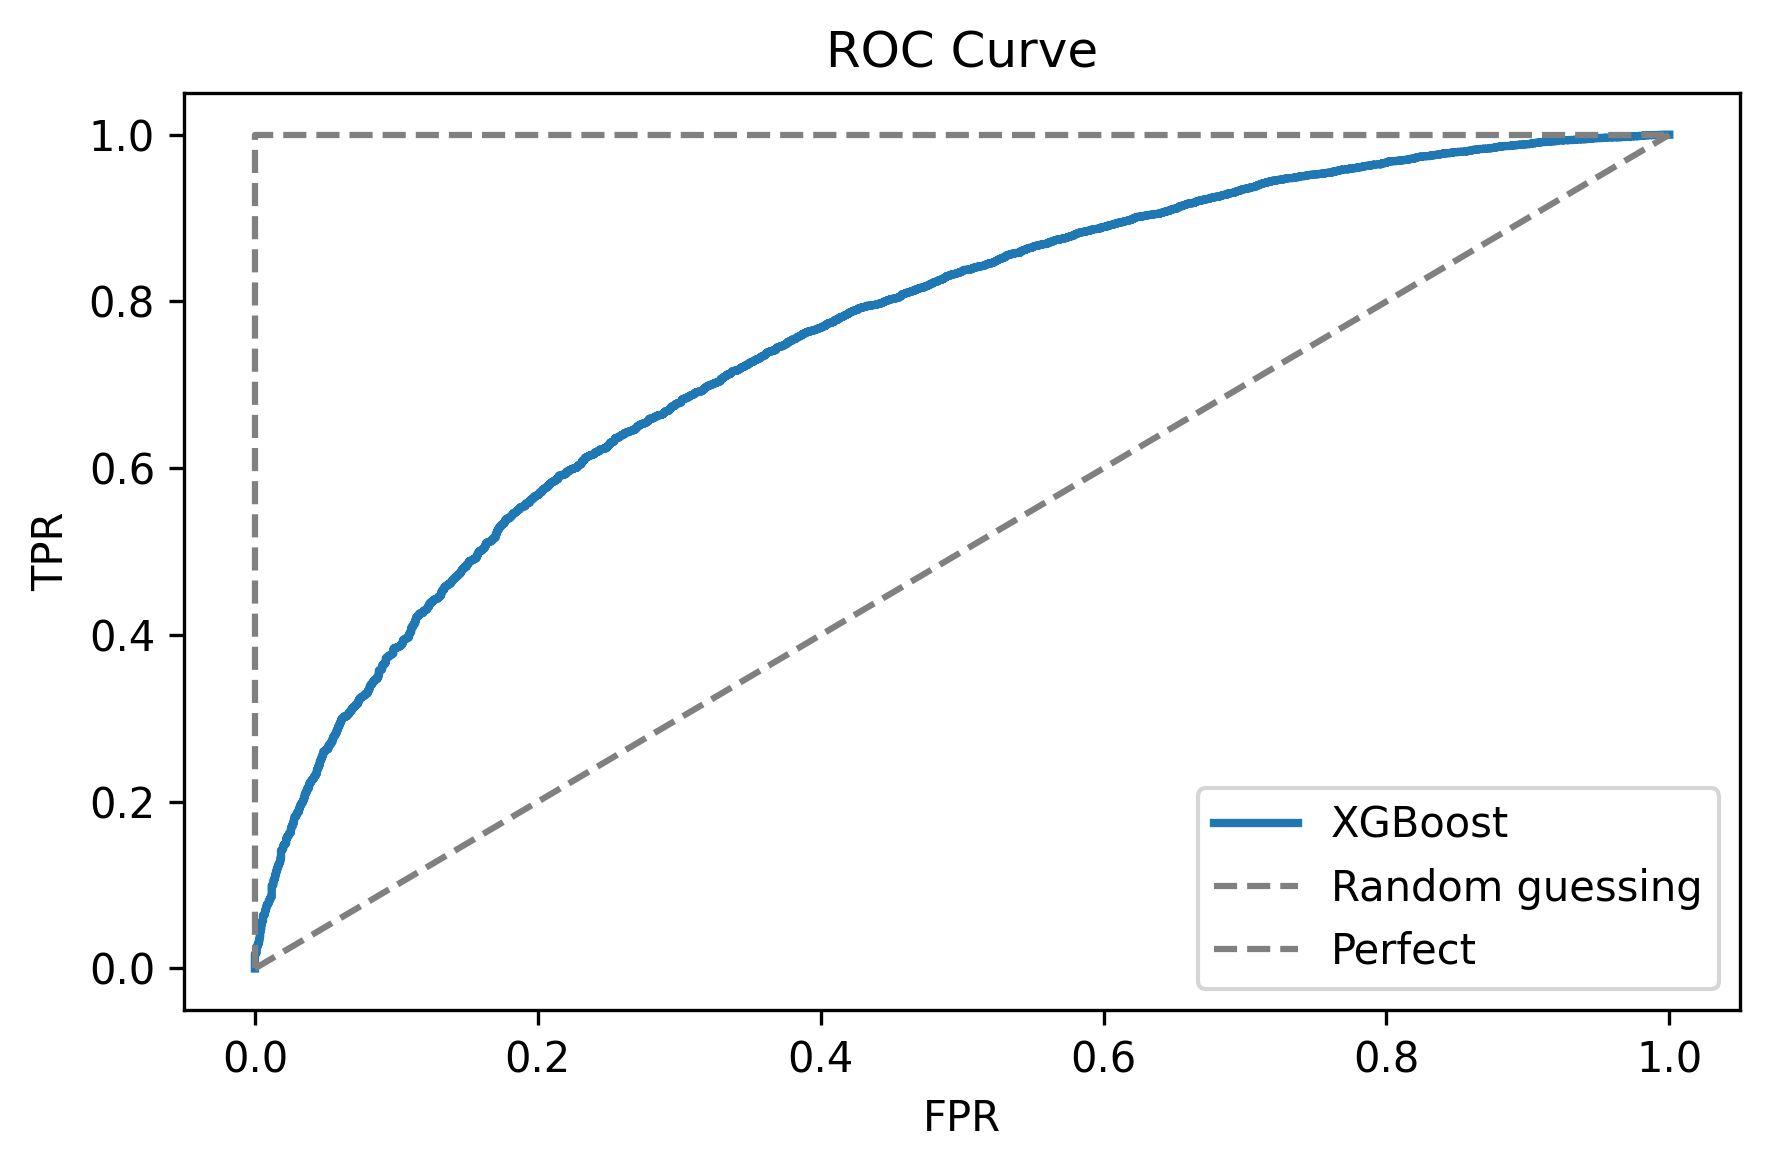

In [21]:
#probas = Model.predict_proba(x_test)
probas =xgbc_finale.predict_proba(imb["X_test"])
y_test = imb["y_test"]

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)

print('AUC: %f' %(auc(fpr, tpr)))

plt.plot(fpr, tpr, lw=2,
         label='XGBoost')
    
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='--',
         color='gray',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_imb_XGBC.png', transparent = True)
plt.show()